In [ ]:
# https://github.com/huggingface/peft/blob/main/examples/sequence_classification/IA3.ipynb

In [ ]:
!pip install accelerate -U
!pip install transformers datasets evaluate accelerate peft

In [ ]:
from google.colab import drive
import pandas as pd
import os
import torch
import peft
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    IA3Config,
    PeftType,
)

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Comp545_FinalProject/code')

from model.train import training_loop
from model.evaluate import evaluate_model
from utils.funcs import load_data, load_tokenizer_model, prepare_dataloader
from utils.plot import plot_confusion_matrix
from utils.test_cases import run_test_cases

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Mounted at /content/drive


## Train and evaluate on combine data

In [ ]:
train_combine_data_path = "../data_PEFT/lab-manual-combine-train.xlsx"
test_combine_data_path = "../data_PEFT/lab-manual-combine-test.xlsx"

sentences_combine, labels_combine, sentences_test_combine, labels_test_combine = load_data(train_combine_data_path, test_combine_data_path)

In [ ]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_combine, labels_combine, batch_size, device, return_train_dataloader=True)
test_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_test_combine, labels_test_combine, batch_size, device, return_train_dataloader=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Size: 4568, Validation Size: 1141


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Size: 1428


https://huggingface.co/docs/peft/en/package_reference/ia3








In [ ]:
peft_config = peft.IA3Config(task_type="SEQ_CLS", inference_mode=False)
peft_type = peft.PeftType.IA3

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_IA3 = get_peft_model(model, peft_config)
model_IA3.print_trainable_parameters()
model_IA3
# trainable params: 1,224,707 || all params: 356,587,526 || trainable%: 0.34345200286114325

In [ ]:
optimizer = AdamW(params=model.parameters(), lr=1e-3)
num_epochs = 10
num_training_steps = len(train_val_dataloader_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [ ]:
accuracy_list, f1_list = training_loop(model_IA3, device, num_epochs, train_val_dataloader_combine, optimizer, lr_scheduler)

100%|██████████| 286/286 [07:20<00:00,  1.54s/it]


Epoch [1/10], Training loss: 0.5862


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]


Epoch [1/10], Validation accuracy:
{'accuracy': 0.544259421560035}
Epoch [1/10], Validation f1:
{'f1': 0.5068197927526928}
---------------------------------------------------


100%|██████████| 286/286 [06:55<00:00,  1.45s/it]


Epoch [2/10], Training loss: 0.6027


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]


Epoch [2/10], Validation accuracy:
{'accuracy': 0.7861524978089395}
Epoch [2/10], Validation f1:
{'f1': 0.7852490952549127}
---------------------------------------------------


100%|██████████| 286/286 [06:54<00:00,  1.45s/it]


Epoch [3/10], Training loss: 0.4659


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]


Epoch [3/10], Validation accuracy:
{'accuracy': 0.8343558282208589}
Epoch [3/10], Validation f1:
{'f1': 0.8358541317330677}
---------------------------------------------------


100%|██████████| 286/286 [06:54<00:00,  1.45s/it]


Epoch [4/10], Training loss: 0.1999


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]


Epoch [4/10], Validation accuracy:
{'accuracy': 0.873794916739702}
Epoch [4/10], Validation f1:
{'f1': 0.8743945948826783}
---------------------------------------------------


100%|██████████| 286/286 [06:54<00:00,  1.45s/it]


Epoch [5/10], Training loss: 0.1404


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]


Epoch [5/10], Validation accuracy:
{'accuracy': 0.9395267309377738}
Epoch [5/10], Validation f1:
{'f1': 0.9396744032154833}
---------------------------------------------------


100%|██████████| 286/286 [06:54<00:00,  1.45s/it]


Epoch [6/10], Training loss: 0.0212


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]


Epoch [6/10], Validation accuracy:
{'accuracy': 0.9465381244522348}
Epoch [6/10], Validation f1:
{'f1': 0.9464982680174834}
---------------------------------------------------


100%|██████████| 286/286 [06:54<00:00,  1.45s/it]


Epoch [7/10], Training loss: 0.0067


100%|██████████| 72/72 [00:50<00:00,  1.44it/s]


Epoch [7/10], Validation accuracy:
{'accuracy': 0.9517966695880806}
Epoch [7/10], Validation f1:
{'f1': 0.951763600123847}
---------------------------------------------------


100%|██████████| 286/286 [06:54<00:00,  1.45s/it]


Epoch [8/10], Training loss: 0.2726


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]


Epoch [8/10], Validation accuracy:
{'accuracy': 0.9570552147239264}
Epoch [8/10], Validation f1:
{'f1': 0.9571266241143072}
---------------------------------------------------


100%|██████████| 286/286 [06:54<00:00,  1.45s/it]


Epoch [9/10], Training loss: 0.0011


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]


Epoch [9/10], Validation accuracy:
{'accuracy': 0.9588080631025416}
Epoch [9/10], Validation f1:
{'f1': 0.9588650389833916}
---------------------------------------------------


100%|██████████| 286/286 [06:54<00:00,  1.45s/it]


Epoch [10/10], Training loss: 0.0004


100%|██████████| 72/72 [00:50<00:00,  1.44it/s]

Epoch [10/10], Validation accuracy:
{'accuracy': 0.9517966695880806}
Epoch [10/10], Validation f1:
{'f1': 0.951763600123847}
---------------------------------------------------


In [ ]:
accuracy_list

[{'accuracy': 0.544259421560035},
 {'accuracy': 0.7861524978089395},
 {'accuracy': 0.8343558282208589},
 {'accuracy': 0.873794916739702},
 {'accuracy': 0.9395267309377738},
 {'accuracy': 0.9465381244522348},
 {'accuracy': 0.9517966695880806},
 {'accuracy': 0.9570552147239264},
 {'accuracy': 0.9588080631025416},
 {'accuracy': 0.9517966695880806}]

In [ ]:
f1_list

[{'f1': 0.5068197927526928},
 {'f1': 0.7852490952549127},
 {'f1': 0.8358541317330677},
 {'f1': 0.8743945948826783},
 {'f1': 0.9396744032154833},
 {'f1': 0.9464982680174834},
 {'f1': 0.951763600123847},
 {'f1': 0.9571266241143072},
 {'f1': 0.9588650389833916},
 {'f1': 0.951763600123847}]

In [ ]:
accuracy, f1, predictions_list, labels_list = evaluate_model(model_IA3, test_dataloader_combine, device)

Test accuracy:  {'accuracy': 0.9607843137254902}
Test f1:  {'f1': 0.960782287247412}


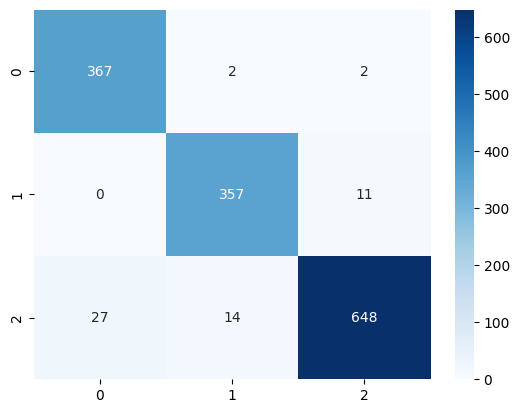

In [ ]:
plot_confusion_matrix(labels_list, predictions_list)

In [ ]:
# test some cases
IA3_model_combinedata_name = 'IA3-model-combinedata'
IA3_tokenizer_combinedata_name = 'IA3-tokenizer-combinedata'

# Save model
tokenizer.save_pretrained(IA3_tokenizer_combinedata_name)
model_IA3.save_pretrained(IA3_model_combinedata_name)

run_test_cases(IA3_model_combinedata_name, IA3_tokenizer_combinedata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Hawkish
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Dovish
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Hawkish
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Hawkish
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Dovish


## Train and evaluate on split combine  data

In [ ]:
train_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-train.xlsx"
test_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-test.xlsx"

sentences_split_combine, labels_split_combine, sentences_test_split_combine, labels_test_split_combine = load_data(train_split_combine_data_path,
                                                                                                                   test_split_combine_data_path)

In [ ]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                        sentences_split_combine,
                                                        labels_split_combine,
                                                        batch_size,
                                                        device,
                                                        return_train_dataloader=True)
test_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                   sentences_test_split_combine,
                                                   labels_test_split_combine,
                                                   batch_size,
                                                   device,
                                                   return_train_dataloader=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Size: 4762, Validation Size: 1190


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Size: 1488


In [ ]:
peft_config = peft.IA3Config(task_type="SEQ_CLS", inference_mode=False)
peft_type = peft.PeftType.IA3

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_IA3 = get_peft_model(model, peft_config)
model_IA3.print_trainable_parameters()
model_IA3
# trainable params: 1,224,707 || all params: 356,587,526 || trainable%: 0.34345200286114325

In [ ]:
optimizer = AdamW(params=model.parameters(), lr=1e-3)
num_epochs = 10
num_training_steps = len(train_val_dataloader_split_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_split_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [ ]:
accuracy_list_splitdata, f1_list_splitdata = training_loop(model_IA3,
                                                           device,
                                                           num_epochs,
                                                           train_val_dataloader_split_combine,
                                                           optimizer,
                                                           lr_scheduler)

100%|██████████| 298/298 [07:46<00:00,  1.57s/it]


Epoch [1/10], Training loss: 0.9915


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [1/10], Validation accuracy:
{'accuracy': 0.6605042016806723}
Epoch [1/10], Validation f1:
{'f1': 0.6634452546783947}
---------------------------------------------------


100%|██████████| 298/298 [07:10<00:00,  1.45s/it]


Epoch [2/10], Training loss: 0.8040


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [2/10], Validation accuracy:
{'accuracy': 0.7739495798319328}
Epoch [2/10], Validation f1:
{'f1': 0.7686428051681364}
---------------------------------------------------


100%|██████████| 298/298 [07:11<00:00,  1.45s/it]


Epoch [3/10], Training loss: 0.3766


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [3/10], Validation accuracy:
{'accuracy': 0.8319327731092437}
Epoch [3/10], Validation f1:
{'f1': 0.8332649904859317}
---------------------------------------------------


100%|██████████| 298/298 [07:10<00:00,  1.45s/it]


Epoch [4/10], Training loss: 0.1437


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [4/10], Validation accuracy:
{'accuracy': 0.8899159663865546}
Epoch [4/10], Validation f1:
{'f1': 0.8879150907334958}
---------------------------------------------------


100%|██████████| 298/298 [07:11<00:00,  1.45s/it]


Epoch [5/10], Training loss: 0.0086


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [5/10], Validation accuracy:
{'accuracy': 0.9352941176470588}
Epoch [5/10], Validation f1:
{'f1': 0.9353003773597097}
---------------------------------------------------


100%|██████████| 298/298 [07:11<00:00,  1.45s/it]


Epoch [6/10], Training loss: 0.0032


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [6/10], Validation accuracy:
{'accuracy': 0.9436974789915966}
Epoch [6/10], Validation f1:
{'f1': 0.9435940429242369}
---------------------------------------------------


100%|██████████| 298/298 [07:11<00:00,  1.45s/it]


Epoch [7/10], Training loss: 0.0073


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [7/10], Validation accuracy:
{'accuracy': 0.9605042016806723}
Epoch [7/10], Validation f1:
{'f1': 0.9605340056988518}
---------------------------------------------------


100%|██████████| 298/298 [07:11<00:00,  1.45s/it]


Epoch [8/10], Training loss: 0.0035


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [8/10], Validation accuracy:
{'accuracy': 0.9647058823529412}
Epoch [8/10], Validation f1:
{'f1': 0.9647177771747293}
---------------------------------------------------


100%|██████████| 298/298 [07:10<00:00,  1.45s/it]


Epoch [9/10], Training loss: 0.0267


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch [9/10], Validation accuracy:
{'accuracy': 0.9638655462184874}
Epoch [9/10], Validation f1:
{'f1': 0.9639048715316008}
---------------------------------------------------


100%|██████████| 298/298 [07:10<00:00,  1.45s/it]


Epoch [10/10], Training loss: 0.0004


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]

Epoch [10/10], Validation accuracy:
{'accuracy': 0.9647058823529412}
Epoch [10/10], Validation f1:
{'f1': 0.9646937821444088}
---------------------------------------------------


In [ ]:
accuracy_list_splitdata

[{'accuracy': 0.6605042016806723},
 {'accuracy': 0.7739495798319328},
 {'accuracy': 0.8319327731092437},
 {'accuracy': 0.8899159663865546},
 {'accuracy': 0.9352941176470588},
 {'accuracy': 0.9436974789915966},
 {'accuracy': 0.9605042016806723},
 {'accuracy': 0.9647058823529412},
 {'accuracy': 0.9638655462184874},
 {'accuracy': 0.9647058823529412}]

In [ ]:
f1_list_splitdata

[{'f1': 0.6634452546783947},
 {'f1': 0.7686428051681364},
 {'f1': 0.8332649904859317},
 {'f1': 0.8879150907334958},
 {'f1': 0.9353003773597097},
 {'f1': 0.9435940429242369},
 {'f1': 0.9605340056988518},
 {'f1': 0.9647177771747293},
 {'f1': 0.9639048715316008},
 {'f1': 0.9646937821444088}]

In [ ]:
accuracy_splitdata, f1_splitdata, predictions_list_splitdata, labels_list_splitdata = evaluate_model(model_IA3,
                                                                                                     test_dataloader_split_combine,
                                                                                                     device)

Test accuracy:  {'accuracy': 0.9623655913978495}
Test f1:  {'f1': 0.9623605394855421}


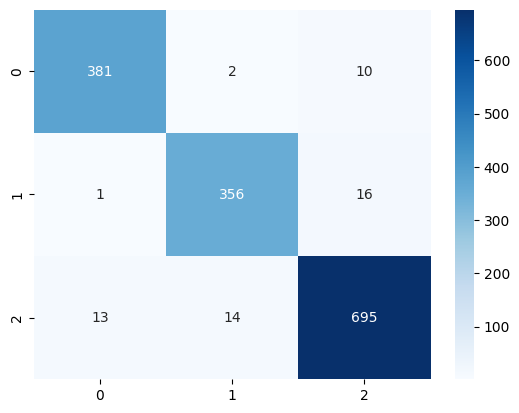

In [ ]:
plot_confusion_matrix(labels_list_splitdata, predictions_list_splitdata)

In [ ]:
# test some cases
IA3_model_splitdata_name = 'IA3-model-splitdata'
IA3_tokenizer_splitdata_name = 'IA3-tokenizer-splitdata'

# Save model
tokenizer.save_pretrained(IA3_tokenizer_splitdata_name)
model_IA3.save_pretrained(IA3_model_splitdata_name)

run_test_cases(IA3_model_splitdata_name, IA3_tokenizer_splitdata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Hawkish
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Dovish
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Hawkish
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Hawkish
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Dovish
